#### 본 매뉴얼에서는 상태공간모형(State-space model) 중 은닉인자모형의 추정에 대해 다룬다.
- 작성자: 고려대학교 경제학과 강규호 교수, 디지털신기술팀 이창훈 과장

<h4 style="text-align: center; font-size: 30px;">은닉인자모형 (Unobserved Component Model)</h4>

$\ \  \  \  \  $ \* $y_t =$ 시점 $t$의 불안정 시계열 관측치

1. 측정식

$\ \  \  \  \  $ \* $y_t$는 추세($\tau_t$)와 순환($c_t$)으로 분해

$$y_t = \tau_t + c_t$$
    
    
2. 전환식

$\ \  \  \  \  $ \* 추세는 drift가 있는 임의보행(random walk with drift) 과정을 따른다고 가정

$$\tau_t = \delta_{t-1} + \tau_{t-1} + N(0, {\sigma_{\tau}}^{2})$$

$\ \  \  \  \  $ \* 순환은 stationary AR(P) 과정을 따른다고 가정

$$c_t = \phi_1 c_{t-1} +\phi_2 c_{t-2}+..+\phi_P c_{t-P} + N(0, {\sigma_{c}}^{2})$$

$\ \  \  \  \  $ \* ${\sigma_{\tau}}^{2}$와 ${\sigma_{c}}^{2}$은 아래와 같이 비례한다고 가정

$$ {\sigma_{c}}^{2} = \lambda {\sigma_{\tau}}^{2} $$

$\ \  \  \  \  $ \* $\lambda$가 클수록 순환의 변동성이 커지고 추세는 변동성이 작아집니다. 따라서 $\lambda$가 클수록 관측치의 변동을 순환이 많이 설명하게 됩니다. 반대로 $\lambda$가 작을수록 관측치 중 추세의 의해서 설명되는 부분이 많아집니다. 이러한 제약없이 추정하면 관측치가 거의 대부분 추세 또는 순환 중 하나에 의해서 설명되는 문제(pile-up problem)가 발생합니다.

3. Drift 항($\delta_{t-1}$)에 대한 세 가지 옵션

$\ \  \  \  \  $옵션 (1): Drift 항이 0인 경우. 즉 $\delta_{t-1} = 0$ for all $t$. 불안정계열이면서 상승 또는 감소 추세가 없는 경우 (예를 들어, 물가상승률이나 금리, 또는 환율 등)

$\ \  \  \  \  $옵션 (2): Drift 항이 상수인 경우. 즉 $\delta_{t-1} =$ non-zeor constant for all $t$. 상승 또는 감소 추세가 있는 불안정계열이며, 상승 또는 감소 속도(즉, 증가율)이 대체로 일정한 경우 (예를 들어, 선진국의 로그 실질 GDP)

$\ \  \  \  \  $옵션 (3): Drift 항이 시변하는 경우. 이 때 Drift 항은 임의보행을 따른다고 가정. 즉 

$$\delta_{t} = \delta_{t-1} + N(0, {\sigma_{d}}^2)$$ 



$\ \  \  \  \  \ \ \ \ \ \ \ \ $상승 또는 감소 추세가 있는 불안정계열이며, 상승 또는 감소 속도(즉, 증가율)가 점차작으로 시변하는 경우 (예를 들어, 신흥국 로그 실질 GDP)

<단계 1> 분석에 필요한 기본 라이브러리 호출

In [4]:
import numpy as np
import pandas as pd

<단계 2> `bok_da` 라이브러리 호출

In [5]:
import bok_da as bd

<단계 3> 데이터 불러오기
- Pandas와 DataFrame에 익숙하지 않은 사용자는 아래 데이터불러오기 코드를 한줄씩 서로 다른 셀에 실행하고 결과를 보는 것을 추천한다. 참고로 원천기관에서 raw 데이터를 불러오고 전처리하는 과정이 복잡해 보일 수 있지만, 한번 해두면 크게 코드를 수정할 필요없이 새로운 데이터에 대해서도 분석 가능한 형태로 전처리 할 수 있기 때문에 장기적으로 효율적인 방법이다.

In [6]:
# 데이터 불러오기(한국 실질 GDP, rGDP)
df = pd.read_excel('../data/Data_BayesEcon.xlsx', sheet_name='GDP') # 엑셀 데이터를 불러온다.
df = df.set_index('통계표') # 통계표라는 이름의 열을 df의 인덱스(행 날짜정보)로 지정한다.
df = df.iloc[4:, :] # 앞의 4개 시점 데이터를 제외힌다.
df.index.name = None # 인덱스 이름을 제거한다.
df.index = df.index.str.replace("/", "-") # 날짜인덱스로 만들기 위해 날짜 형식을 2000/03에서 2000-03과 같이 바꾼다.
df.index = pd.to_datetime(df.index) + pd.offsets.QuarterEnd(0) # 인덱스를 날짜로 변환한다.
df.columns = ['rGDP'] # 데이터 변수명을 rGDP로 설정
df['rGDP'] = np.log(df['rGDP'].astype(float)) * 100 # 전처리
df

,rGDP
1981-03-31,1071.295003
1981-06-30,1073.681833
1981-09-30,1077.760329
1981-12-31,1079.316939
1982-03-31,1079.993266
...,...
2022-09-30,1311.044888
2022-12-31,1310.741460
2023-03-31,1311.070792
2023-06-30,1311.677600


<단계 4> `bok_da` 라이브러리-시계열분석 패키지(`ts`)-상태공간모형 서브패키지(`ssm`)에서 은닉인자모형 추정을 위한 `uc` 함수를 불러온다. 모형 하이퍼파라미터를 `lag=1`, `lamb=3`, `drift='time-varying`으로 설정한다. 참고로 파이썬에서 `lambda`는 예약어로 사용되기 때문에 특정 변수를 lambda로 지정할 수 없다.

`drift`는 `time-varying`외에 `zero`와 `constant`로 설정할 수 있다. `lag`은 AR 과정의 시차로 4이하로 설정하는 것을 권장한다. `lambda_uc`는 값이 클수록 추세의 변동성에 비해 순환부분의 변동성이 커진다. 먼저 1로 설정해서 추정한 다음, 추정결과를 확인하면서 값을 키우거나 줄이는 것을 추천한다.

In [7]:
from bok_da.ts.ssm import uc

In [8]:
Y = df.copy()
res = uc(Y, lag=1, lamb=3, drift='time-varying', verbose=False)

10/10 cycle finished


참고로, 위 셀에서 Y = df로 작성할 경우, Y 값이 변경되면 원본 DataFrame인 df도 변경된다. 파이썬에서 원본 데이터를 보호하고자 하는 경우, 위 셀과 같이 Y = df.copy() 를 사용하는 것이 일반적이다.

res는 다음의 결과를 포함한다. res.drift와 같이 입력하면 확인할 수 있다.

In [9]:
res.get_description()

,설명
drift,Drift 시계열 추정치
drift_se,Drift의 표준오차 시계열 추정치
trend,추세 시계열 추정치
trend_se,추세 표준오차 시계열 추정치
cycle,순환 시계열 추정치
cycle_se,순환 표준오차 시계열 추정치
table,모형 파라미터 추정결과
lnL,로그우도(log likelihood)
bic,베이지안 정보기준(Bayesian Information Criterion)


In [10]:
res.cycle

,cycle
1981-03-31,-1.460756
1981-06-30,-1.244957
1981-09-30,0.239627
1981-12-31,-0.255581
1982-03-31,-1.462344
...,...
2022-09-30,0.456118
2022-12-31,-0.181247
2023-03-31,-0.328725
2023-06-30,-0.263027


In [11]:
res.table

,추정치,표준오차
순환 충격 분산,1.273,0.153
Drift 충격 분산,0.009,0.007
추세 충격 분산,0.424,0.051
AR(1),0.873,0.086


res의 `plot_uc_components` 메서드를 이용해서 추정된 요인의 그림을 그릴 수 있다. 다음 코드에서 `comp`가 그리고자 하는 요인 옵션이며 'trend', 'cycle', 'drift' 옵션이 있다. figsize는 그림의 크기, lgd_ncol은 범례에 표시되는 열의 수를 의미한다.

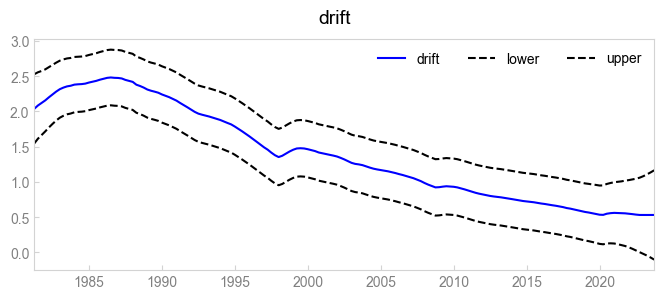

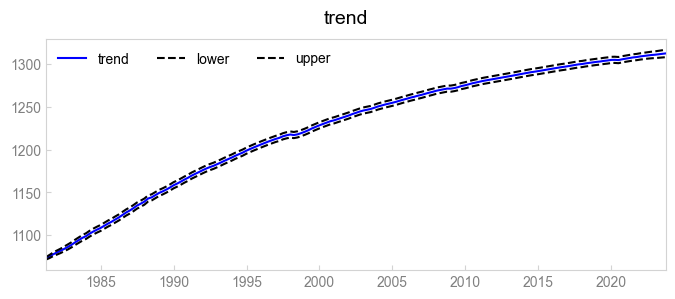

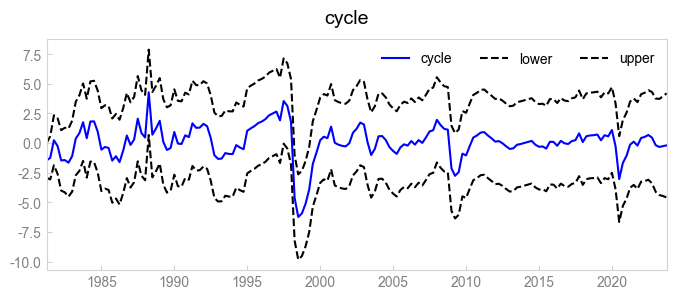

In [13]:
res.plot_uc_components(comp=['drift', 'trend', 'cycle'], figsize=(8,3), ncol=3)

## UnobservedComponentModel 클래스로 모형 설정하고, 추정하기

모형 클래스 불러오기
- `uc` 함수를 불러오는 방법외에 `UnobservedComponentModel` 클래스를 이용한 추정도 가능하다.

`ssm` 서브패키지에서 `UnobservedComponentModel` 클래스를 `UC`로 불러온다.

In [14]:
from bok_da.ts.ssm import UnobservedComponentModel as UC

`UC` 클래스를 이용해 model 객체를 생성하고, `fit` 메서드를 이용해 추정한다.

In [15]:
model = UC(drift='time-varying', lag=1, lamb=3)
res = model.fit(Y, verbose=False)

10/10 cycle finished


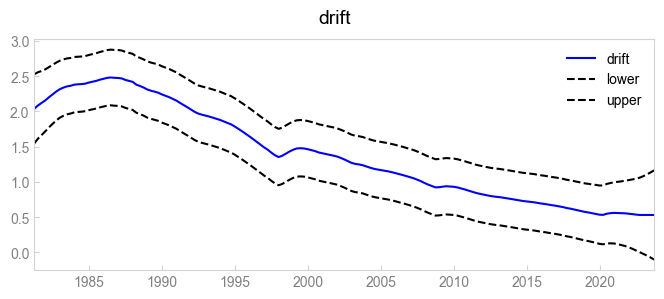

In [16]:
res.plot_uc_components(comp=['drift'], figsize=(8,3))